<a href="https://colab.research.google.com/github/dgiri4132/adaptivegarchmodel/blob/main/adaptivegarchmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 14.6 MB/s eta 0:00:00


In [32]:
import yfinance as yf
import pandas as pd
tickers=[t.upper() for t in input('Enter Stocks tickers(separated by space like aapl msft tsla):').split()]
start_date=input('Enter the start date in yyyy-mm-dd format:')
end_date=input('Enter the end date in yyyy-mm-dd format:')
forecast_horizon=int(input('Enter number of days ahead that you want the projection: '))
price_data=yf.download(tickers,start_date,end_date,auto_adjust=False)['Adj Close']
snp=yf.download('^GSPC',start_date,end_date,auto_adjust=False)['Adj Close']
price_data.dropna(axis=1, how='all', inplace=True)
return_data=price_data.pct_change().dropna()
tickers = price_data.columns.tolist()

Enter Stocks tickers(separated by space like aapl msft tsla):aapl jnj jpm amzn goog ups pg xom
Enter the start date in yyyy-mm-dd format:2024-01-01
Enter the end date in yyyy-mm-dd format:2025-05-01
Enter number of days ahead that you want the projection: 15


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


Enter the rolling window size(has to be at most 216 ):216
JPM failed to fit at index 232, skipping it.
PG failed to fit at index 232, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 232, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 233, skipping it.
PG failed to fit at index 233, skipping it.
UPS failed to fit at index 233, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 234, skipping it.
PG failed to fit at index 234, skipping it.
UPS failed to fit at index 234, skipping it.
JPM failed to fit at index 235, skipping it.
PG failed to fit at index 235, skipping it.
UPS failed to fit at index 235, skipping it.
JPM failed to fit at index 236, skipping it.
PG failed to fit at index 236, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 236, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 237, skipping it.
PG failed to fit at index 237, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 237, skipping it.
JPM failed to fit at index 238, skipping it.
PG failed to fit at index 238, skipping it.
UPS failed to fit at index 238, skipping it.
JPM failed to fit at index 239, skipping it.
PG failed to fit at index 239, skipping it.
UPS failed to fit at index 239, skipping it.
JPM failed to fit at index 240, skipping it.
PG failed to fit at index 240, skipping it.
UPS failed to fit at index 240, skipping it.
JPM failed to fit at index 241, skipping it.
PG failed to fit at index 241, skipping it.
UPS failed to fit at index 241, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 242, skipping it.
PG failed to fit at index 242, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 242, skipping it.
JPM failed to fit at index 243, skipping it.
PG failed to fit at index 243, skipping it.
UPS failed to fit at index 243, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 244, skipping it.
PG failed to fit at index 244, skipping it.
UPS failed to fit at index 244, skipping it.
JPM failed to fit at index 245, skipping it.
PG failed to fit at index 245, skipping it.
UPS failed to fit at index 245, skipping it.
JPM failed to fit at index 246, skipping it.
PG failed to fit at index 246, skipping it.
UPS failed to fit at index 246, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 247, skipping it.
PG failed to fit at index 247, skipping it.
UPS failed to fit at index 247, skipping it.
JPM failed to fit at index 248, skipping it.
PG failed to fit at index 248, skipping it.
UPS failed to fit at index 248, skipping it.
JPM failed to fit at index 249, skipping it.
PG failed to fit at index 249, skipping it.
UPS failed to fit at index 249, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 250, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


PG failed to fit at index 250, skipping it.
UPS failed to fit at index 250, skipping it.
JPM failed to fit at index 251, skipping it.
PG failed to fit at index 251, skipping it.
UPS failed to fit at index 251, skipping it.
JPM failed to fit at index 252, skipping it.
PG failed to fit at index 252, skipping it.
UPS failed to fit at index 252, skipping it.
JPM failed to fit at index 253, skipping it.
PG failed to fit at index 253, skipping it.
UPS failed to fit at index 253, skipping it.
JPM failed to fit at index 254, skipping it.
PG failed to fit at index 254, skipping it.
UPS failed to fit at index 254, skipping it.
JPM failed to fit at index 255, skipping it.
PG failed to fit at index 255, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 255, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 256, skipping it.
PG failed to fit at index 256, skipping it.
UPS failed to fit at index 256, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 257, skipping it.
PG failed to fit at index 257, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 257, skipping it.
JPM failed to fit at index 258, skipping it.
PG failed to fit at index 258, skipping it.
UPS failed to fit at index 258, skipping it.
JPM failed to fit at index 259, skipping it.
PG failed to fit at index 259, skipping it.
UPS failed to fit at index 259, skipping it.
JPM failed to fit at index 260, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


PG failed to fit at index 260, skipping it.
UPS failed to fit at index 260, skipping it.
JPM failed to fit at index 261, skipping it.
PG failed to fit at index 261, skipping it.
UPS failed to fit at index 261, skipping it.
JPM failed to fit at index 262, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


PG failed to fit at index 262, skipping it.
UPS failed to fit at index 262, skipping it.
JPM failed to fit at index 263, skipping it.
PG failed to fit at index 263, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 263, skipping it.
JPM failed to fit at index 264, skipping it.
PG failed to fit at index 264, skipping it.
UPS failed to fit at index 264, skipping it.
JPM failed to fit at index 265, skipping it.
PG failed to fit at index 265, skipping it.
UPS failed to fit at index 265, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 266, skipping it.
PG failed to fit at index 266, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 266, skipping it.
JNJ failed to fit at index 267, skipping it.
JPM failed to fit at index 267, skipping it.
PG failed to fit at index 267, skipping it.
UPS failed to fit at index 267, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JNJ failed to fit at index 268, skipping it.
JPM failed to fit at index 268, skipping it.
PG failed to fit at index 268, skipping it.
UPS failed to fit at index 268, skipping it.
JNJ failed to fit at index 269, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 269, skipping it.
PG failed to fit at index 269, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 269, skipping it.
JNJ failed to fit at index 270, skipping it.
JPM failed to fit at index 270, skipping it.
PG failed to fit at index 270, skipping it.
UPS failed to fit at index 270, skipping it.
JNJ failed to fit at index 271, skipping it.
JPM failed to fit at index 271, skipping it.
PG failed to fit at index 271, skipping it.
UPS failed to fit at index 271, skipping it.
JNJ failed to fit at index 272, skipping it.
JPM failed to fit at index 272, skipping it.
PG failed to fit at index 272, skipping it.
UPS failed to fit at index 272, skipping it.
JNJ failed to fit at index 273, skipping it.
JPM failed to fit at index 273, skipping it.
PG failed to fit at index 273, skipping it.
UPS failed to fit at index 273, skipping it.
JNJ failed to fit at index 274, skipping it.
JPM failed to fit at index 274, skipping it.
PG failed to fit at index 274, skipping it.
UPS failed to fit at index 274, skipping it.
JNJ failed to fit at index 275, skipping it.
JPM failed to f

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 276, skipping it.
JNJ failed to fit at index 277, skipping it.
JPM failed to fit at index 277, skipping it.
PG failed to fit at index 277, skipping it.
UPS failed to fit at index 277, skipping it.
JNJ failed to fit at index 278, skipping it.
JPM failed to fit at index 278, skipping it.
PG failed to fit at index 278, skipping it.
UPS failed to fit at index 278, skipping it.
JNJ failed to fit at index 279, skipping it.
JPM failed to fit at index 279, skipping it.
PG failed to fit at index 279, skipping it.
UPS failed to fit at index 279, skipping it.
JNJ failed to fit at index 280, skipping it.
JPM failed to fit at index 280, skipping it.
PG failed to fit at index 280, skipping it.
UPS failed to fit at index 280, skipping it.
JNJ failed to fit at index 281, skipping it.
JPM failed to fit at index 281, skipping it.
PG failed to fit at index 281, skipping it.
UPS failed to fit at index 281, skipping it.
JNJ failed to fit at index 282, skipping it.
JPM failed to f

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 286, skipping it.
JNJ failed to fit at index 287, skipping it.
JPM failed to fit at index 287, skipping it.
PG failed to fit at index 287, skipping it.
UPS failed to fit at index 287, skipping it.
JNJ failed to fit at index 288, skipping it.
JPM failed to fit at index 288, skipping it.
PG failed to fit at index 288, skipping it.
UPS failed to fit at index 288, skipping it.
JNJ failed to fit at index 289, skipping it.
JPM failed to fit at index 289, skipping it.
PG failed to fit at index 289, skipping it.
UPS failed to fit at index 289, skipping it.
JNJ failed to fit at index 290, skipping it.
JPM failed to fit at index 290, skipping it.
PG failed to fit at index 290, skipping it.
UPS failed to fit at index 290, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JNJ failed to fit at index 291, skipping it.
JPM failed to fit at index 291, skipping it.
PG failed to fit at index 291, skipping it.
UPS failed to fit at index 291, skipping it.
JNJ failed to fit at index 292, skipping it.
JPM failed to fit at index 292, skipping it.
PG failed to fit at index 292, skipping it.
UPS failed to fit at index 292, skipping it.
JNJ failed to fit at index 293, skipping it.
JPM failed to fit at index 293, skipping it.
PG failed to fit at index 293, skipping it.
UPS failed to fit at index 293, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JNJ failed to fit at index 294, skipping it.
JPM failed to fit at index 294, skipping it.
PG failed to fit at index 294, skipping it.
UPS failed to fit at index 294, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JNJ failed to fit at index 295, skipping it.
JPM failed to fit at index 295, skipping it.
PG failed to fit at index 295, skipping it.
UPS failed to fit at index 295, skipping it.
GOOG failed to fit at index 296, skipping it.
JPM failed to fit at index 296, skipping it.
PG failed to fit at index 296, skipping it.
UPS failed to fit at index 296, skipping it.
GOOG failed to fit at index 297, skipping it.
JPM failed to fit at index 297, skipping it.
PG failed to fit at index 297, skipping it.
UPS failed to fit at index 297, skipping it.
GOOG failed to fit at index 298, skipping it.
JPM failed to fit at index 298, skipping it.
PG failed to fit at index 298, skipping it.
UPS failed to fit at index 298, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GOOG failed to fit at index 299, skipping it.
JPM failed to fit at index 299, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


PG failed to fit at index 299, skipping it.
UPS failed to fit at index 299, skipping it.
AMZN failed to fit at index 300, skipping it.
GOOG failed to fit at index 300, skipping it.
JPM failed to fit at index 300, skipping it.
PG failed to fit at index 300, skipping it.
UPS failed to fit at index 300, skipping it.
GOOG failed to fit at index 301, skipping it.
JPM failed to fit at index 301, skipping it.
PG failed to fit at index 301, skipping it.
UPS failed to fit at index 301, skipping it.
JPM failed to fit at index 302, skipping it.
PG failed to fit at index 302, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 302, skipping it.
GOOG failed to fit at index 303, skipping it.
JPM failed to fit at index 303, skipping it.
PG failed to fit at index 303, skipping it.
UPS failed to fit at index 303, skipping it.
GOOG failed to fit at index 304, skipping it.
JPM failed to fit at index 304, skipping it.
PG failed to fit at index 304, skipping it.
UPS failed to fit at index 304, skipping it.
GOOG failed to fit at index 305, skipping it.
JPM failed to fit at index 305, skipping it.
PG failed to fit at index 305, skipping it.
UPS failed to fit at index 305, skipping it.
GOOG failed to fit at index 306, skipping it.
JPM failed to fit at index 306, skipping it.
PG failed to fit at index 306, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 306, skipping it.
GOOG failed to fit at index 307, skipping it.
JPM failed to fit at index 307, skipping it.
PG failed to fit at index 307, skipping it.
UPS failed to fit at index 307, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


GOOG failed to fit at index 308, skipping it.
JPM failed to fit at index 308, skipping it.
PG failed to fit at index 308, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 308, skipping it.
JPM failed to fit at index 309, skipping it.
PG failed to fit at index 309, skipping it.
UPS failed to fit at index 309, skipping it.
GOOG failed to fit at index 310, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 310, skipping it.
PG failed to fit at index 310, skipping it.
UPS failed to fit at index 310, skipping it.
GOOG failed to fit at index 311, skipping it.
JPM failed to fit at index 311, skipping it.
PG failed to fit at index 311, skipping it.
UPS failed to fit at index 311, skipping it.
AMZN failed to fit at index 312, skipping it.
GOOG failed to fit at index 312, skipping it.
JPM failed to fit at index 312, skipping it.
PG failed to fit at index 312, skipping it.
UPS failed to fit at index 312, skipping it.
JNJ failed to fit at index 313, skipping it.
JPM failed to fit at index 313, skipping it.
PG failed to fit at index 313, skipping it.
UPS failed to fit at index 313, skipping it.
AAPL failed to fit at index 314, skipping it.
AMZN failed to fit at index 314, skipping it.
GOOG failed to fit at index 314, skipping it.
JNJ failed to fit at index 314, skipping it.
JPM failed to fit at index 314, skipping it.
PG failed to fit at index 314, skipping it.
UPS faile

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


JPM failed to fit at index 315, skipping it.
PG failed to fit at index 315, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


UPS failed to fit at index 315, skipping it.
XOM failed to fit at index 315, skipping it.
AAPL failed to fit at index 316, skipping it.
AMZN failed to fit at index 316, skipping it.
GOOG failed to fit at index 316, skipping it.
JNJ failed to fit at index 316, skipping it.
JPM failed to fit at index 316, skipping it.


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


PG failed to fit at index 316, skipping it.
UPS failed to fit at index 316, skipping it.
XOM failed to fit at index 316, skipping it.
Backtest Results: 
Annualized Sharpe Ratio: -0.827351
Average Turnover: 0.153990
Total failures: 316


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<Figure size 900x400 with 0 Axes>

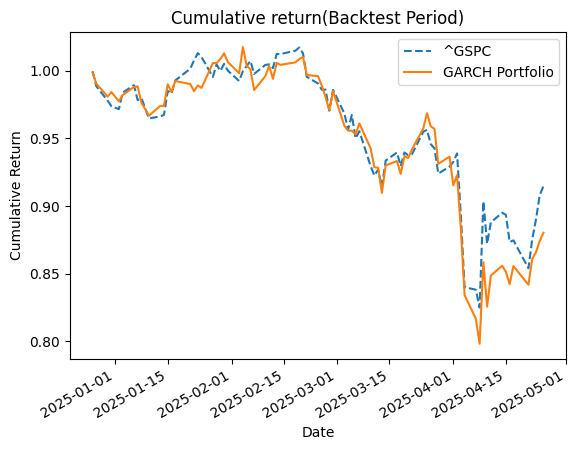

In [35]:
#Analyzing residuals for best model to use
from arch import arch_model
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
split_idx=int(len(return_data)*0.7)
train_data=return_data.iloc[:split_idx]
test_data=return_data.iloc[split_idx:]
max_rolling_window = split_idx - forecast_horizon-1
def residual_analyze(return_series):
  model=arch_model(return_series,vol='GARCH',p=1,q=1,dist='normal', rescale=False)
  result=model.fit(disp='off')
  resid=result.resid
  cond_vol=result.conditional_volatility
  std_resid=resid/cond_vol
  s=skew(std_resid)
  k=kurtosis(std_resid,fisher=True)
  return s, k, result
rolling_window=int(input(f'Enter the rolling window size(has to be at most {max_rolling_window} ):'))
rolling_weights=[]
rolling_dates=[]
rolling_returns=[]
prev_weights=None
turnovers=[]
vol_forecast_log=[]
fit_failures=0
for i in range(split_idx,len(return_data)-forecast_horizon):
  window_data=return_data.iloc[i-rolling_window:i]
  vol_today={}
  for ticker in tickers:
    series=window_data[ticker]
    s,k,_=residual_analyze(series)
    if abs(s)>0.5 and k>3:
      model=arch_model(series,vol='EGARCH',p=1,o=1,q=1,dist='skewt', rescale=False)
    elif abs(s)>0.5:
      model=arch_model(series,vol='EGARCH',p=1,o=1,q=1,dist='normal', rescale=False)
    elif k>3:
      model=arch_model(series,vol='GARCH',p=1,q=1,dist='t',rescale=False)
    else:
      model=arch_model(series,vol='GARCH',p=1,q=1,dist='normal', rescale=False)
    try:
      result=model.fit(disp='off', options={'maxiter':2000})
      forecast=result.forecast(horizon=forecast_horizon)
      variance_series = forecast.variance.iloc[-1,:forecast_horizon].mean()
      vol_today[ticker] = np.sqrt(variance_series)

    except Exception as e:
      print(f'{ticker} failed to fit at index {i}, skipping it.')
      vol_today[ticker]=np.nan
      fit_failures+=1
      continue
  vol_series=pd.Series(vol_today).dropna()
  vol_forecast_log.append((return_data.index[i+forecast_horizon],vol_series))
  if vol_series.empty:
    continue
  inv_vol=1/vol_series
  weights=inv_vol/inv_vol.sum()
  weights=weights.reindex(tickers).fillna(0)
  if weights[weights>0].count()<2:
    continue
  if prev_weights is not None:
    turnover=np.sum(np.abs(weights-prev_weights))
    turnovers.append(turnover)
  prev_weights=weights
  try:
    future_return=return_data.iloc[i+forecast_horizon][tickers]
    daily_returns=(future_return*weights).sum()
    rolling_weights.append(weights)
    rolling_dates.append(return_data.index[i+forecast_horizon])
    rolling_returns.append(daily_returns)
  except:
    continue
portfolio_returns=pd.Series(rolling_returns,index=rolling_dates)
cumulative_returns=(1+portfolio_returns).cumprod()
rf_daily=0.03/252
excess_return=portfolio_returns-rf_daily
trading_days=portfolio_returns.count()
sharpe_ratio=excess_return.mean()/excess_return.std()*np.sqrt(trading_days)
avg_turnover=np.mean(turnovers)

print('Backtest Results: ')
print(f'Annualized Sharpe Ratio: {sharpe_ratio:2f}')
print(f'Average Turnover: {avg_turnover:2f}')
snp_returns=snp.pct_change().dropna()
snp_test=snp_returns.loc[portfolio_returns.index]
snp_cum_test=(1+snp_test).cumprod()
print(f'Total failures: {fit_failures}')
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
snp_cum_test.plot(label='S&P 500',linestyle='--')
cumulative_returns.plot(label='GARCH Portfolio')
plt.title('Cumulative return(Backtest Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
